In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel("data/MPVDatasetDownload.xlsx", sheet_name="2013-2020 Police Killings")

In [3]:
df.head()

,Victim's name,Victim's age,Victim's gender,Victim's race,URL of image of victim,Date of Incident (month/day/year),Street Address of Incident,City,State,Zipcode,...,Unarmed/Did Not Have an Actual Weapon,Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database),Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),WaPo ID (If included in WaPo database),Off-Duty Killing?,Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-content/uploads/2015/05/full-ZCTA-urban-suburban-rural-classification.xlsx ),MPV ID,Fatal Encounters ID
0,Pedro Martinez,66,Male,Hispanic,NaN,2020-11-18,NaN,Tyler,TX,NaN,...,Allegedly Armed,unknown weapon,other,not fleeing,no,6321.0,NaN,NaN,NaN,NaN
1,James Horton,42,Male,NaN,NaN,2020-11-17,NaN,Hart County,KY,NaN,...,Allegedly Armed,gun,attack,other,no,6322.0,NaN,NaN,NaN,NaN
2,Dustin James Acosta,28,Male,White,NaN,2020-11-17,NaN,St. Augustine,FL,NaN,...,Allegedly Armed,gun,attack,NaN,No,6320.0,NaN,NaN,NaN,NaN
3,Javon Brice,39,Male,NaN,NaN,2020-11-17,NaN,La Vergne,TN,NaN,...,Allegedly Armed,gun,attack,car,no,6319.0,NaN,NaN,NaN,NaN
4,Joshua D. Evans,32,Male,NaN,NaN,2020-11-16,NaN,Batesville,IN,NaN,...,Allegedly Armed,gun,attack,not fleeing,no,6314.0,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['Victim's name', 'Victim's age', 'Victim's gender', 'Victim's race',
       'URL of image of victim', 'Date of Incident (month/day/year)',
       'Street Address of Incident', 'City', 'State', 'Zipcode', 'County',
       'Agency responsible for death', 'ORI Agency Identifier (if available)',
       'Cause of death',
       'A brief description of the circumstances surrounding the death',
       'Official disposition of death (justified or other)',
       'Criminal Charges?',
       'Link to news article or photo of official document',
       'Symptoms of mental illness?', 'Unarmed/Did Not Have an Actual Weapon',
       'Alleged Weapon (Source: WaPo and Review of Cases Not Included in WaPo Database)',
       'Alleged Threat Level (Source: WaPo)', 'Fleeing (Source: WaPo)',
       'Body Camera (Source: WaPo)', 'WaPo ID (If included in WaPo database)',
       'Off-Duty Killing?',
       'Geography (via Trulia methodology based on zipcode population density: http://jedkolko.com/wp-co

In [5]:
df = df[["Victim's race", "Date of Incident (month/day/year)", "State"] ]

In [6]:
df.head()

,Victim's race,Date of Incident (month/day/year),State
0,Hispanic,2020-11-18,TX
1,NaN,2020-11-17,KY
2,White,2020-11-17,FL
3,NaN,2020-11-17,TN
4,NaN,2020-11-16,IN


In [7]:
df.columns = ["race", "date", "state"]

In [8]:
df["race"] = df.race.apply(lambda x: "Unknown" if x == "Unknown race" or x == "Unknown Race" or x == "unknown race" else x).iloc[:]

In [9]:
df.fillna("Unknown", inplace=True)

In [10]:
#df = df[(df["race"] == "White") | (df["race"] == "Black") | (df["race"] == "Hispanic")].reset_index(drop = True).iloc[:]

In [11]:
df.head(10)

,race,date,state
0,Hispanic,2020-11-18,TX
1,Unknown,2020-11-17,KY
2,White,2020-11-17,FL
3,Unknown,2020-11-17,TN
4,Unknown,2020-11-16,IN
5,Unknown,2020-11-16,FL
6,Unknown,2020-11-15,TX
7,White,2020-11-14,NH
8,Hispanic,2020-11-14,CA
9,Unknown,2020-11-14,TX


In [12]:
df.race.value_counts()

White               3769
Black               2158
Hispanic            1482
Unknown              922
Asian                132
Native American      120
Pacific Islander      46
Name: race, dtype: int64

## Total

In [13]:
def get_week(df, event):
    filtered = df[(df["date"] <= event)]
    return filtered.iloc[-1]["date"], filtered.index[-1]

In [54]:
def get_next_weeks(df, event, weeks):
    pos = get_week(df, event)[1]
    if pos + weeks + 1 > len(df):
        return df.iloc[pos:].total_victims.mean()
    else:
        return df.iloc[pos + 1: pos + weeks + 1].total_victims.mean()

In [55]:
def get_previous_weeks(df, event, weeks):
    pos = get_week(df, event)[1]
    if pos - weeks < 0:
        return df.iloc[:pos].total_victims.mean()
    else:
        return df.iloc[pos - weeks:pos].total_victims.mean()

In [52]:
def blm_march_influence(df, year, events, weeks, minority = None):
    
    df = df[(df["date"] >= f"{year}-01-01") & (df["date"] <= f"{year}-12-31")].reset_index(drop = True).iloc[:]
    
    if minority:
        df = df[df["race"] == minority].reset_index(drop = True)
    
    grouped = df.groupby("date")
    killings = {}

    for date in set(df["date"]):
        killings[date] = grouped.get_group(date).size / 3
    
    df = pd.DataFrame(killings.items(), columns = ["date", "total_victims"])
    
    df = df.groupby(pd.Grouper(key = "date", freq = "1W", origin = f"{year}-01-01")).sum().reset_index()
    
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    df.plot(x = "date", y = "total_victims", kind = "line", ax = ax)
    if minority:
        ax.set_ylabel(f"Total {minority} victims")
    else:
        ax.set_ylabel("Total victims")
    ax.get_legend().remove()
    
    for event in events:
        ax.axvline(x=event, color = "red")
        print(f"Average nymber of deaths over the previous {weeks} weeks before the event of {event} :" , get_previous_weeks(df, event, weeks))
        print(f"Average nymber of deaths over the next {weeks} weeks after the event of {event}:" , get_next_weeks(df, event, weeks))
        print()

In [33]:
g_floyd = "2020-05-25"
b_taylor = "2020-03-13"
biggest = "2020-06-06"

events = ["2013-11-02", "2014-07-17", "2014-08-09", "2015-04-12", "2015-11-16", "2015-11-24", "2016-07-05", b_taylor, g_floyd, biggest]

Average nymber of deaths over the previous 5 weeks before the event of 2020-03-13 : 4.0
Average nymber of deaths over the next 5 weeks after the event of 2020-03-13: 4.2

Average nymber of deaths over the previous 5 weeks before the event of 2020-05-25 : 5.6
Average nymber of deaths over the next 5 weeks after the event of 2020-05-25: 5.0

Average nymber of deaths over the previous 5 weeks before the event of 2020-06-06 : 5.4
Average nymber of deaths over the next 5 weeks after the event of 2020-06-06: 3.6



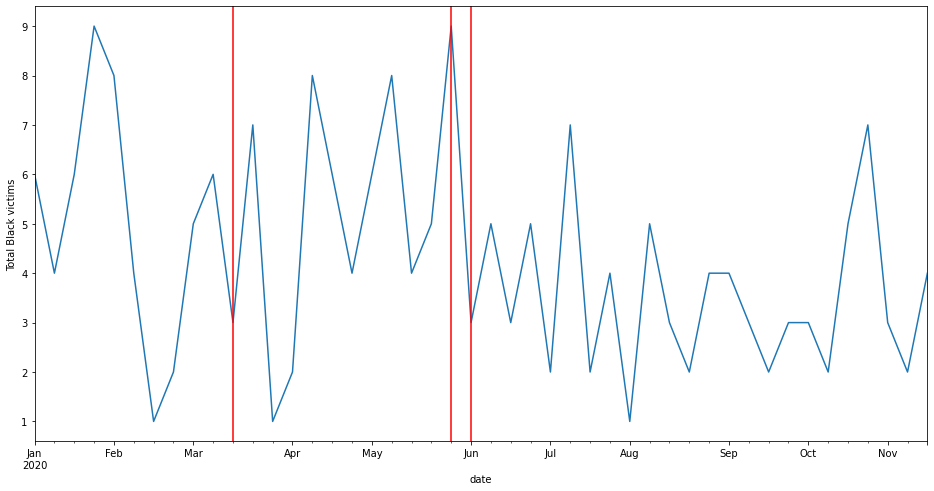

In [34]:
blm_march_influence(df, "2020", events[7:], 5, minority="Black")

In [36]:
event = "2017-02-10"

Average nymber of deaths over the previous 3 weeks before the event of 2017-02-10 : 5.666666666666667
Average nymber of deaths over the next 3 weeks after the event of 2017-02-10: 8.333333333333334



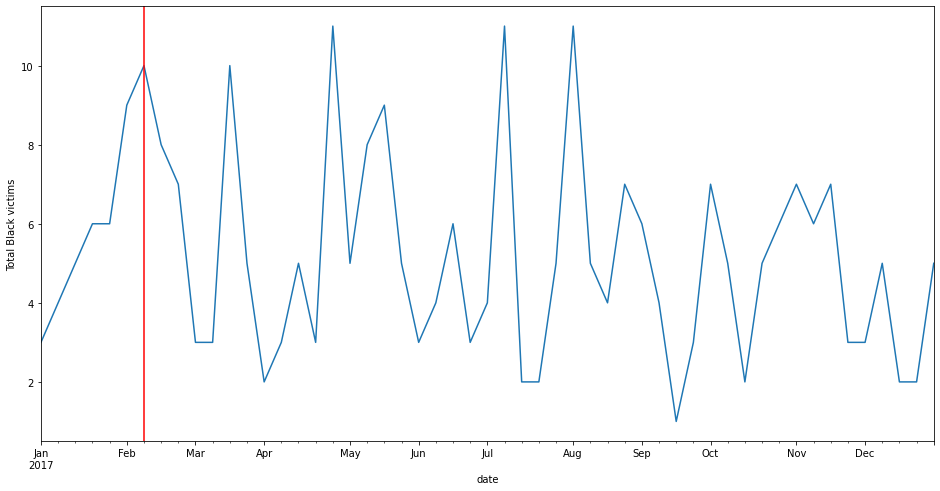

In [60]:
blm_march_influence(df, "2017", [event], 3, minority="Black")

## Per state

In [21]:
df.head()

,race,date,state
0,Black,2020-11-13,FL
1,Black,2020-11-13,FL
2,Black,2020-11-11,OK
3,Black,2020-11-09,MD
4,Black,2020-11-05,TX


In [22]:
per_state = {}
grouped = df.groupby(["state", "date"])
for (state, date) in grouped.groups.keys():
        per_state[(state, date)] = (grouped.get_group((state, date)).size / 3)#, grouped.get_group((state, date))["race"])

In [23]:
per_state = pd.DataFrame(per_state.items(), columns = ["state", "victims"])

In [24]:
per_state["date"] = per_state["state"].apply(lambda x : x[1]).iloc[:]

In [25]:
per_state["state"] = per_state["state"].apply(lambda x : x[0]).iloc[:]

In [26]:
per_state

,state,victims,date
0,AK,1.0,2014-09-15
1,AK,1.0,2017-02-17
2,AK,1.0,2018-08-16
3,AK,1.0,2019-04-01
4,AL,1.0,2013-01-31
...,...,...,...
2087,WV,1.0,2018-02-17
2088,WV,1.0,2018-03-29
2089,WV,1.0,2018-10-04
2090,WV,1.0,2019-01-06


In [27]:
texas = per_state.groupby("state").get_group("TX")

In [28]:
ela = -1
for state in set(per_state["state"]):
    v = per_state.groupby("state").get_group(state)
    print(len(v), state)

52 NJ
79 MO
88 LA
4 NM
191 CA
26 CO
64 PA
10 DE
7 IA
55 VA
45 IN
15 MA
53 OK
169 TX
45 TN
42 SC
9 OR
30 WA
78 NY
56 AL
84 OH
100 IL
35 AR
1 ME
80 NC
25 NV
1 ID
9 UT
85 MD
112 GA
4 AK
11 WV
24 DC
32 WI
45 MI
8 NE
11 KS
1 HI
21 KY
180 FL
33 AZ
8 CT
3 RI
42 MS
19 MN


<AxesSubplot:xlabel='date'>

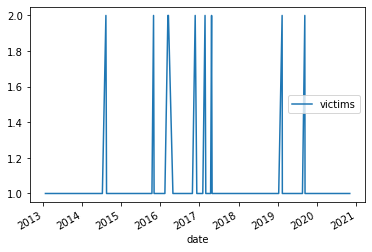

In [29]:
texas.plot(x = "date", y = "victims")

In [30]:
df_total_deaths.sort_values("date")

,date,total_victims
168,2013-01-01,1.0
1126,2013-01-03,1.0
1366,2013-01-04,3.0
857,2013-01-07,1.0
380,2013-01-09,1.0
...,...,...
1234,2020-11-04,1.0
625,2020-11-05,1.0
306,2020-11-09,1.0
795,2020-11-11,1.0


In [31]:
by_week = df_total_deaths.groupby(pd.Grouper(key = "date", freq = "1W", origin = "2013-01-01")).first()

In [32]:
by_week = by_week.reset_index()

<AxesSubplot:xlabel='date'>

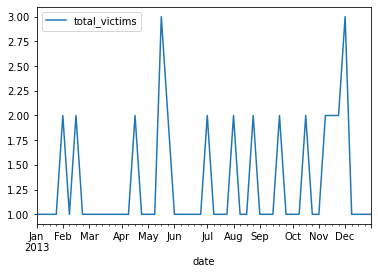

In [33]:
by_week[by_week["date"] < "2013-12-31"].plot(x = "date", y = "total_victims")

In [34]:
by_month = df_total_deaths.groupby(pd.Grouper(key = "date", freq = "1M", origin = "2013-01-01")).first()

In [35]:
by_month.reset_index(inplace=True)

<AxesSubplot:xlabel='date'>

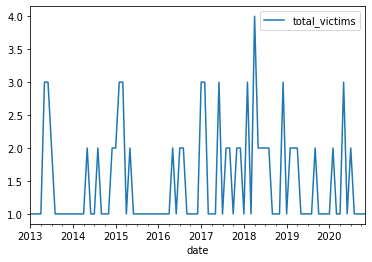

In [36]:
by_month.plot(x = "date", y = "total_victims")

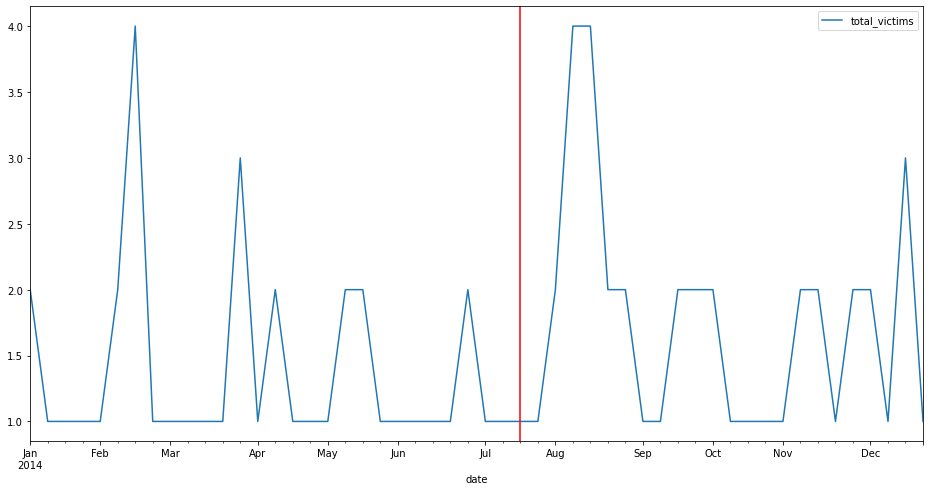

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
by_week[(by_week["date"] > "2013-12-31") & (by_week["date"] <= "2014-12-31")].plot(x = "date", y = "total_victims",ax = ax)
ax.axvline(x="2014-07-17", color = "red")

In [38]:
texas_per_week = texas.groupby(pd.Grouper(key = "date", freq = "1W", origin = "2013-01-01")).sum().reset_index()

In [39]:
texas_per_week.reset_index(inplace=True)

In [40]:
texas_per_week

,index,date,victims
0,0,2013-01-27,1.0
1,1,2013-02-03,0.0
2,2,2013-02-10,0.0
3,3,2013-02-17,1.0
4,4,2013-02-24,0.0
...,...,...,...
402,402,2020-10-11,0.0
403,403,2020-10-18,0.0
404,404,2020-10-25,0.0
405,405,2020-11-01,0.0


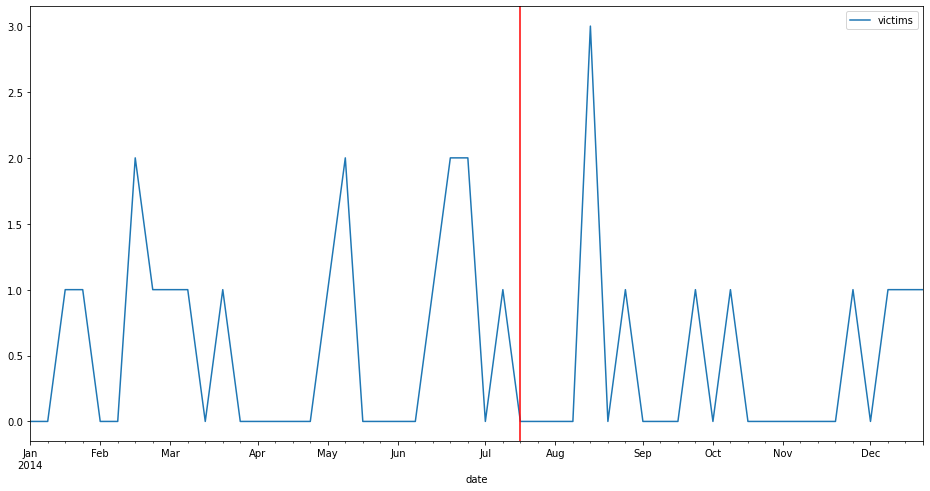

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
texas_per_week[(texas_per_week["date"] > "2013-12-31") & (texas_per_week["date"] <= "2014-12-31")].plot(x = "date", y = "victims",ax = ax)
ax.axvline(x="2014-07-17", color = "red")

In [43]:
mn = per_state.groupby("state").get_group("MN")
mn_per_week = mn.groupby(pd.Grouper(key = "date", freq = "1W", origin = "2013-01-01")).sum().reset_index()
mn_per_week.reset_index(inplace=True)

In [44]:
mn[(mn["date"] > "2014-12-31") & (mn["date"] <= "2015-12-31")]

,state,victims,date
1103,MN,1.0,2015-01-14
1104,MN,1.0,2015-05-08
1105,MN,1.0,2015-11-15


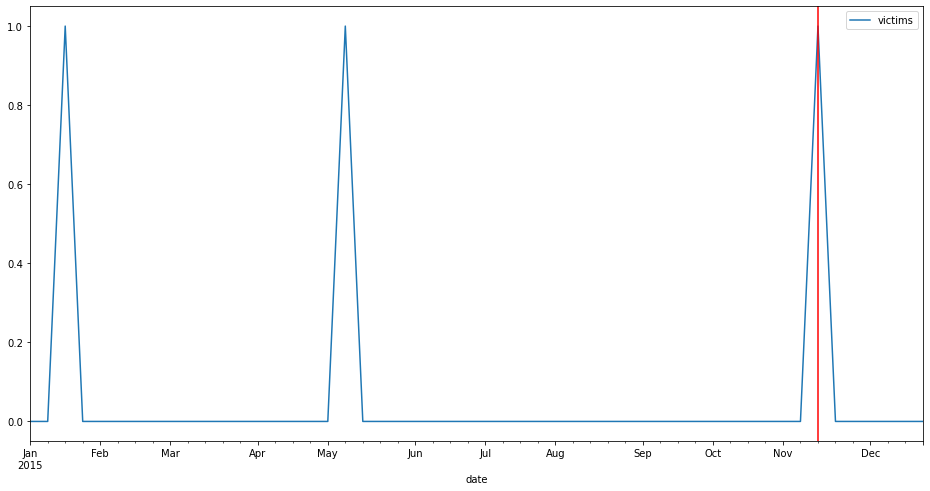

In [45]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
mn_per_week[(mn_per_week["date"] > "2014-12-31") & (mn_per_week["date"] <= "2015-12-31")].plot(x = "date", y = "victims",ax = ax)
ax.axvline(x="2015-11-15", color = "red")

In [46]:
mn

,state,victims,date
1099,MN,1.0,2013-02-12
1100,MN,1.0,2013-05-10
1101,MN,1.0,2013-08-23
1102,MN,1.0,2014-11-02
1103,MN,1.0,2015-01-14
1104,MN,1.0,2015-05-08
1105,MN,1.0,2015-11-15
1106,MN,1.0,2016-05-09
1107,MN,1.0,2016-07-06
1108,MN,1.0,2016-09-17


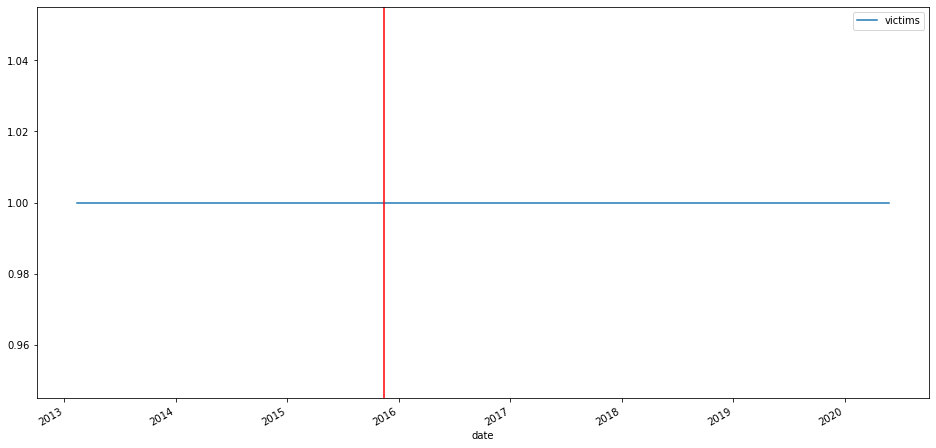

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
mn.plot(x = "date", y = "victims",ax = ax)
ax.axvline(x="2015-11-15", color = "red")